## Before we begin:
## This notebook is mostly from the Deep Reinforcement Learning Class by HuggingFace
Edited by Mohamad Al Mdfaa

---



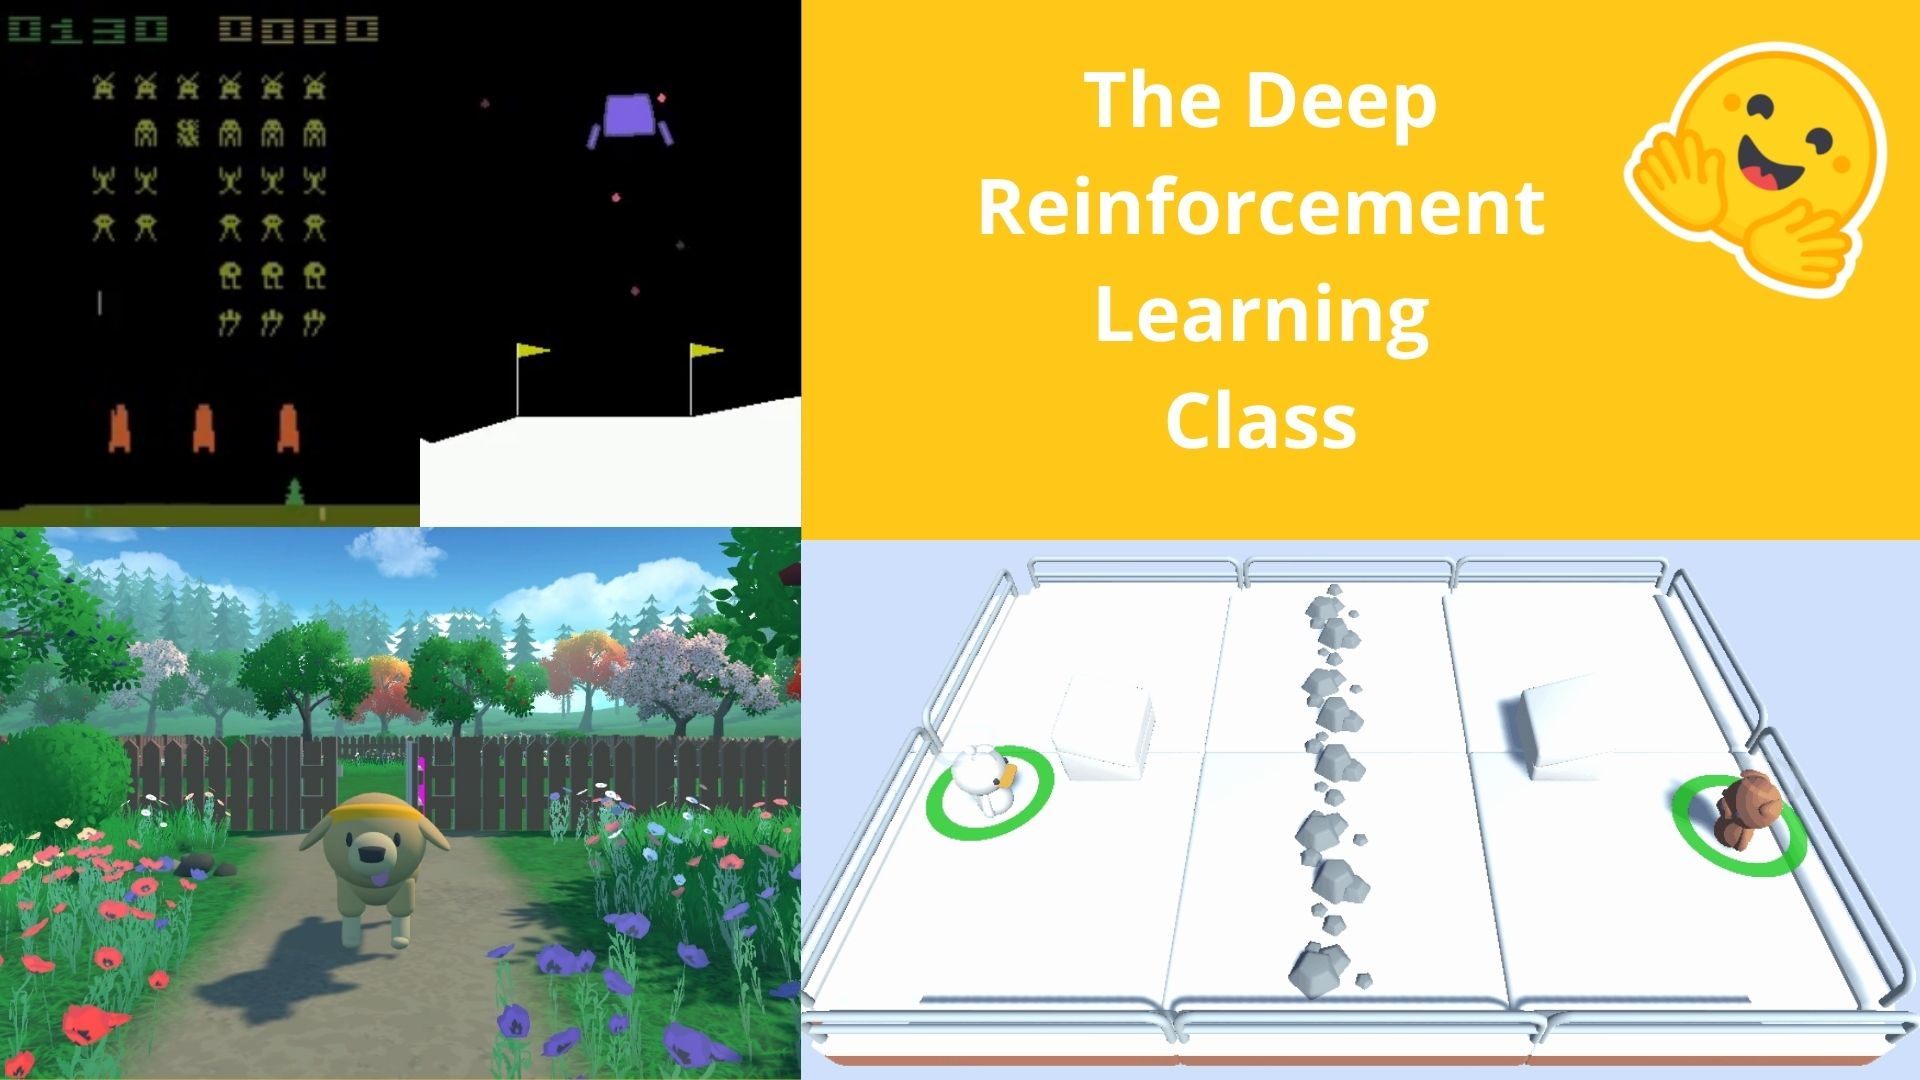

# Q-Learning with FrozenLake-v1 ⛄ and Taxi-v3 🚕

In this lab, **we'll code from scratch our Reinforcement Learning agent** playing FrozenLake ❄️ using Q-Learning, and experiment with different configurations

🎮 Environments: 
- [FrozenLake-v1](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)
- [Taxi-v3](https://www.gymlibrary.dev/environments/toy_text/taxi/)

📚 RL-Library: Python and Numpy

⬇️ Here is an example of what **you will achieve by the end of the lab.** ⬇️

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/envs.gif" alt="environments"/>

## Objectives of this notebook 🏆
At the end of the notebook, you will:
- Use **Gym** environments instead of the Clearning Robot example that we used in our labs.
- Be able to code from scratch a Q-Learning agent.




## A small recap of Q-Learning

- The *Q-Learning* **is the RL algorithm that**  
  - Trains *Q-Function*, an **action-value function** that contains, as internal memory, a *Q-table* **that contains all the state-action pair values.**
    
  - Given a state and action, our Q-Function **will search into its Q-table the corresponding value.**
    

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-function-2.jpg" alt="Q function"/>

- When the training is done,**we have an optimal Q-Function, so an optimal Q-Table.**
    
- And if we **have an optimal Q-function**, we
have an optimal policy,since we **know for each state, what is the best action to take.**


<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/link-value-policy.jpg" alt="Link value policy"/>

But, in the beginning, our **Q-Table is useless since it gives arbitrary value for each state-action pair (most of the time we initialize the Q-Table to 0 values)**. But, as we’ll explore the environment and update our Q-Table it will give us better and better approximations

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-learning-1.jpg" alt="Link value policy"/>

This is the Q-Learning pseudocode:

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-learning-2.jpg" alt="Link value policy"/>


### Step 0: Setup a Virtual Display 💻

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames). 

Hence the following cell will install virtual screen libraries and create and run a virtual screen 🖥

In [ ]:
%%capture
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

### Step 1: Install dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

- `gym`: Contains the FrozenLake-v1 ⛄ and Taxi-v3 🚕 environments.
- `pygame`: Used for the FrozenLake-v1 and Taxi-v3 UI.
- `numPy`: Used for handling our Q-table.

The Hugging Face Hub 🤗 works as a central place where anyone can share and explore models and datasets. It has versioning, metrics, visualizations and other features that will allow you to easily collaborate with others.

You can see here all the Deep reinforcement Learning models available 👉 https://huggingface.co/models?other=q-learning



In [ ]:
%%capture
!pip install gym==0.24 # We install the newest gym version for the Taxi-v3 "rgb_array version"
!pip install pygame
!pip install numpy

!pip install pickle5
!pip install pyyaml==6.0 # avoid key error metadata
!pip install imageio imageio_ffmpeg

### Step 2: Import the packages 📦

In addition to the installed libraries, we also use:

- `random`: To generate random numbers (that will be useful for Epsilon-Greedy Policy).
- `imageio`: To generate a replay video






In [ ]:
import numpy as np
import gym
import random
import imageio
import os

import pickle5 as pickle
from tqdm.notebook import tqdm

We're now ready to code our Q-Learning algorithm 🔥

# Part 1: Frozen Lake ⛄ (non slippery version)

### Step 1: Create and understand [FrozenLake environment ⛄]((https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)
---

💡 A good habit when you start to use an environment is to check its documentation 

👉 https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

---

We're going to train our Q-Learning agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:
- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:
- `is_slippery=False`: The agent always move in the intended direction due to the non-slippery nature of the frozen lake.
- `is_slippery=True`: The agent may not always move in the intended direction due to the slippery nature of the frozen lake (stochastic).

For now let's keep it simple with the 4x4 map and non-slippery

In [ ]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False) # TODO use the correct parameters

### Solution

In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)

You can create your own custom grid like this:

```python
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
gym.make('FrozenLake-v1', desc=desc, is_slippery=True)
```

but we'll use the default environment for now.

### Let's see what the Environment looks like:


In [ ]:
# We create our environment with gym.make("<name_of_the_environment>")
env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

We see with `Observation Space Shape Discrete(16)` that the observation is a value representing the **agent’s current position as current_row * nrows + current_col (where both the row and col start at 0)**. 

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**


For instance, this is what state = 0 looks like:


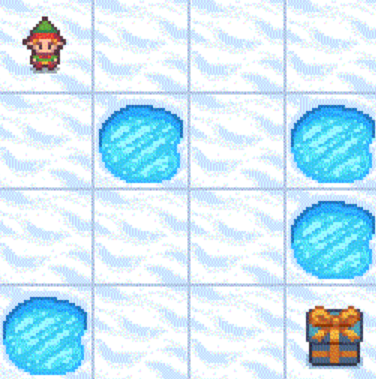

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action

The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### Step 2: Create and Initialize the Q-table 🗄️
(👀 Step 1 of the pseudocode)

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-learning-2.jpg" alt="Q-Learning table"/>

It's time to initialize our Q-table! To know how many rows (states) and columns (actions) to use, we need to know the action and observation space. OpenAI Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`


In [ ]:
env.observation_space.n

In [ ]:
state_space = env.observation_space.n # TODO
print("There are ", state_space, " possible states")

action_space = env.action_space.n # TODO
print("There are ", action_space, " possible actions")

In [ ]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space)) #TODO
  return Qtable

In [ ]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

In [ ]:
Qtable_frozenlake

### Solution

In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

In [ ]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [ ]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

### Step 3: Define the epsilon-greedy policy 🤖

Epsilon-Greedy is the training policy that handles the exploration/exploitation trade-off.

The idea with Epsilon Greedy:

- With *probability 1 - ɛ* : **we do exploitation** (aka our agent selects the action with the highest state-action pair value).

- With *probability ɛ*: we do **exploration** (trying random action).

And as the training goes, we progressively **reduce the epsilon value since we will need less and less exploration and more exploitation.**

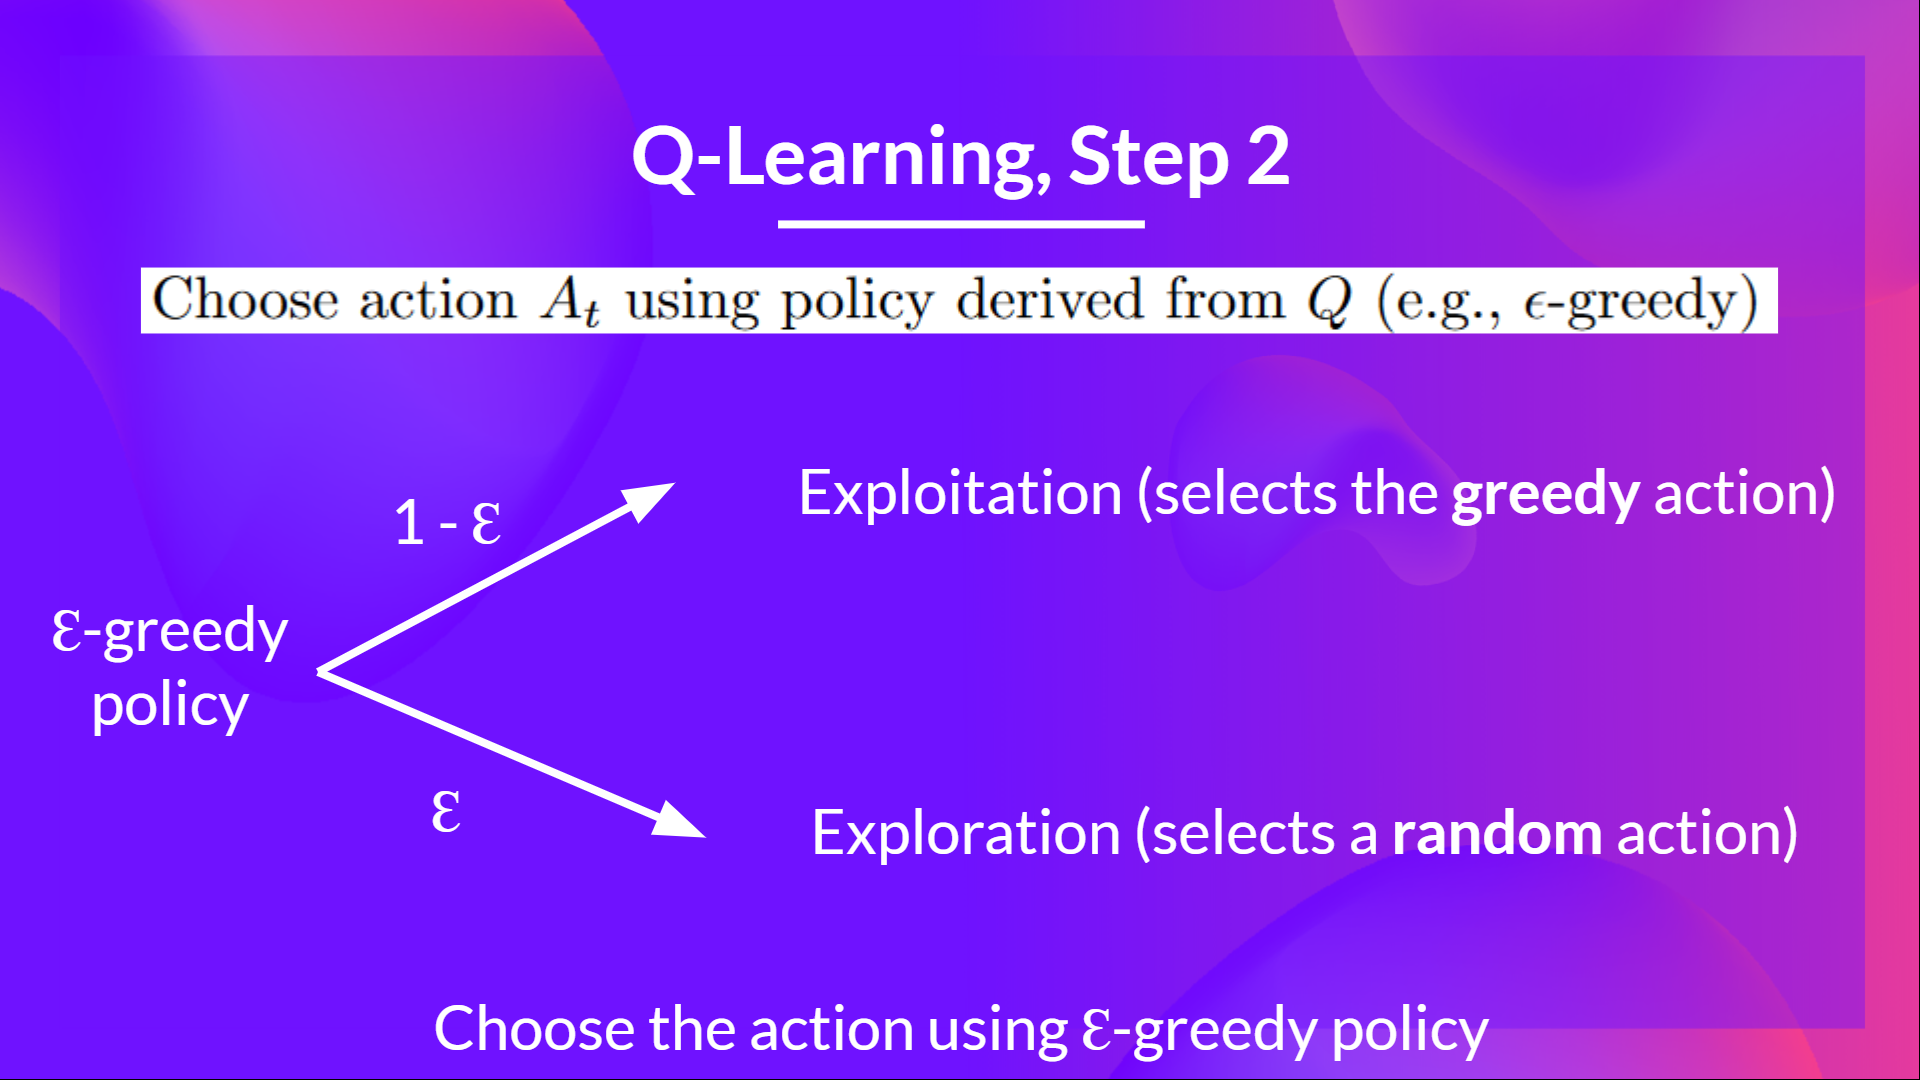

Thanks to Sambit for finding a bug on the epsilon function 🤗

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = np.random.random() # TODO
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = np.argmax(Qtable[state]) #TODO
  # else --> exploration
  else:
    action = env.action_space.sample() # Take a random action
  
  return action

#### Solution

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_int = random.uniform(0,1)
  # if random_int > greater than epsilon --> exploitation
  if random_int > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = np.argmax(Qtable[state])
  # else --> exploration
  else:
    action = env.action_space.sample()
  
  return action

### Step 4: Define the greedy policy 🤖
Remember we have two policies since Q-Learning is an **off-policy** algorithm. This means we're using a **different policy for acting and updating the value function**.

- Epsilon greedy policy (acting policy)
- Greedy policy (updating policy)

Greedy policy will also be the final policy we'll have when the Q-learning agent will be trained. The greedy policy is used to select an action from the Q-table.

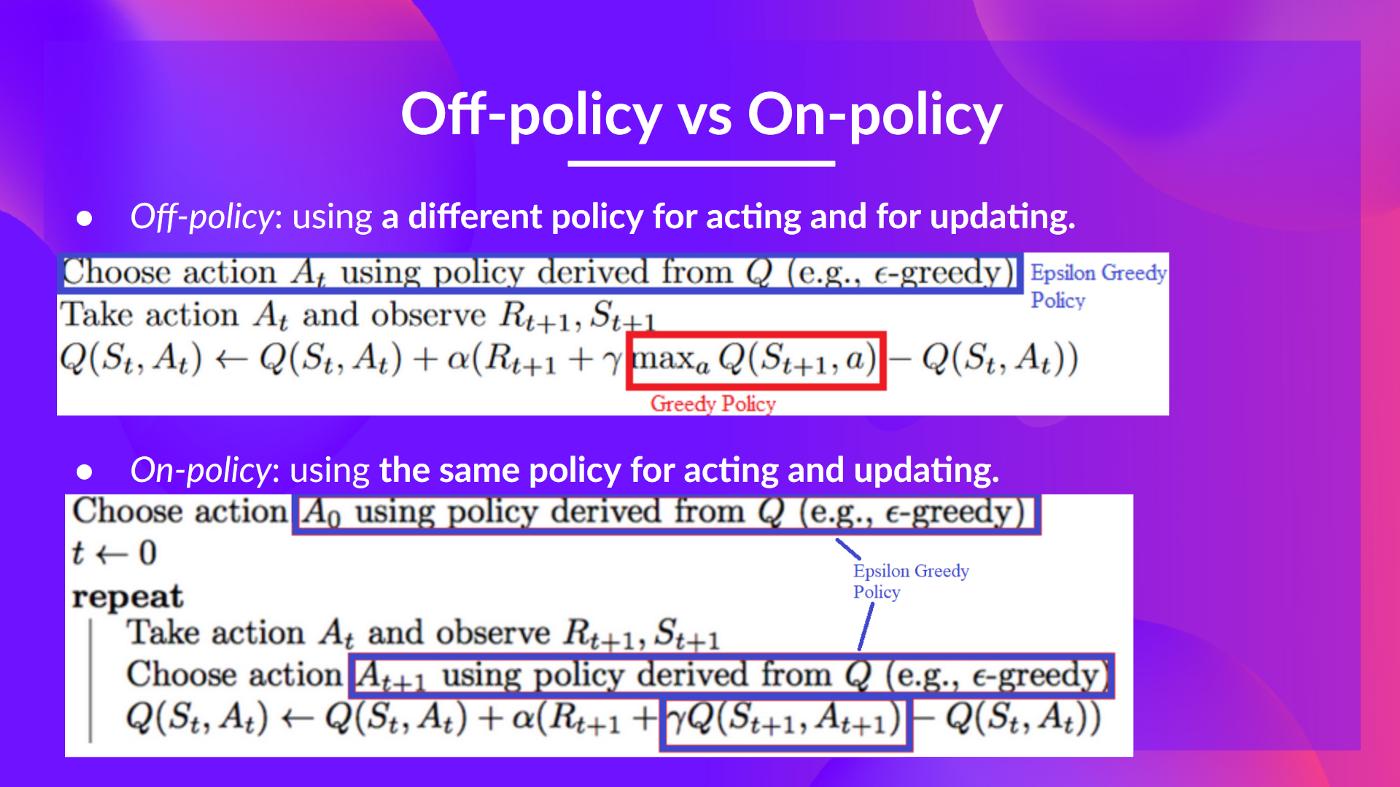

In [ ]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state]) # TODO
  
  return action

#### Solution

In [ ]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])
  
  return action

### Step 5: Define the hyperparameters ⚙️
The exploration related hyperparamters are some of the most important ones. 

- We need to make sure that our agent **explores enough the state space** in order to learn a good value approximation, in order to do that we need to have progressive decay of the epsilon.
- If you decrease too fast epsilon (too high decay_rate), **you take the risk that your agent is stuck**, since your agent didn't explore enough the state space and hence can't solve the problem.

In [ ]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability 
decay_rate = 0.0005            # Exponential decay rate for exploration prob

### Step 6: Create the training loop method

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in range(n_training_episodes):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s') - Q(s,a)]
      Qtable[state][action] += learning_rate * (reward + gamma*np.max(Qtable[new_state]) - Qtable[state][action])# TODO

      # If done, finish the episode
      if done:
        break
      
      # Our state is the new state
      state = new_state
  return Qtable

#### Solution

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])   

      # If done, finish the episode
      if done:
        break
      
      # Our state is the new state
      state = new_state
  return Qtable

### Homework - Task 1

- Make the required changes to the `train` function to implement `SARSA` algorithm with on-policy, Run both of the algorithms (SARSA & Q-Learning) on the [FrozenLake environment ⛄]((https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) environment then compare the results. ***(5 points)***

<img src="https://drive.google.com/uc?id=1Ly9gLnxkMHCpTMcLEboGFq2dhgvSme9l"/>

**Important NOTE:**

**You are free to make any changes to the code that are required to meet the requirements.**

In [ ]:
def train_SARSA(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a)
      Qtable[state][action] =  

      # If done, finish the episode
      if done:
        break
      
      # Our state is the new state
      state = new_state
  return Qtable

### Step 7: Train the Q-Learning agent 🏃

In [ ]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

### Homework
### Step 7: Train the SARSA agent
Do not EDIT

In [ ]:
Qtable_frozenlake = train_SARSA(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

### Step 8: Let's see what our Q-Learning table looks like now 👀

In [ ]:
Qtable_frozenlake

### Step 9: Define the evaluation method 📝

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

### Step 10: Evaluate our Q-Learning agent 📈
- Normally you should have mean reward of 1.0
- It's relatively easy since the state space is really small (16). What you can try to do is [to replace with the slippery version](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/).

In [ ]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Let's create **the model dictionary that contains the hyperparameters and the Q_table**.

In [ ]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []  
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [ ]:
video_path = './replay.mp4'
video_fps = 1
record_video(env, Qtable_frozenlake, video_path, video_fps)

In [ ]:
from ast import Str
from IPython.display import HTML
from base64 import b64encode
# def show_video(video_path):
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
# show_video(video_path)

### Homework - Task 2

- Suggest at least 2 different settings for the following hyperparameters `{[learning_rate_1, gamma_1, max_epsilon_1, min_epsilon_1, decay_rate_1], [learning_rate_2, gamma_2, max_epsilon_2, min_epsilon_2, decay_rate_2], [..], ..}` "Try to cover some interesting/corner cases" and re-train the agents (SARSA & Q-Learning) using the suggested hyperparameters. Write a simple function to **VISUALIZE** the **Reward per Episode** for each of the settings for each of the agents. Compare the results in your own words. (In case of one or more of the suggested settings of the hyperparameters didn't work, write in your own words why do you think it didn't work? and explain how to make it works.). ***(5 Points)***

**Important NOTE:**

**You are free to make any changes to the code that are required to meet the requirements.**

In [ ]:
def visualize():
  #TODO

  pass

# Part 2: Taxi-v3 🚖

### Step 1: Create and understand [Taxi-v3 🚕](https://www.gymlibrary.dev/environments/toy_text/taxi/)
---

💡 A good habit when you start to use an environment is to check its documentation 

👉 https://www.gymlibrary.dev/environments/toy_text/taxi/

---

In Taxi-v3 🚕, there are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

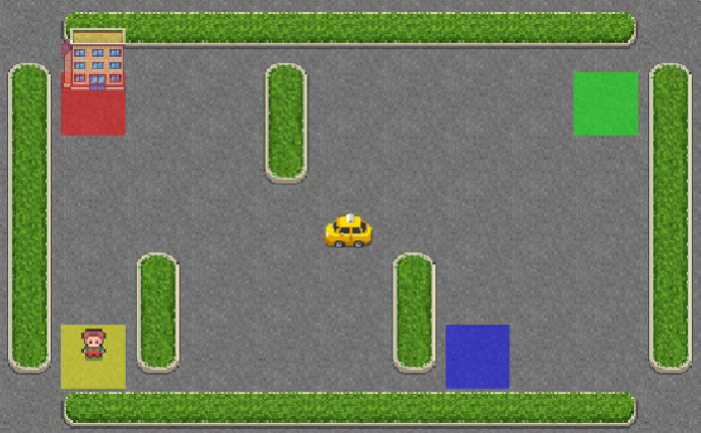

In [ ]:
env = gym.make("Taxi-v3")

There are **500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger** (including the case when the passenger is in the taxi), and **4 destination locations.**


In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

In [ ]:
action_space = env.action_space.n
print("There are ", action_space, " possible actions")

The action space (the set of possible actions the agent can take) is discrete with **6 actions available 🎮**:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

Reward function 💰:
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

In [ ]:
# Create our Q table with state_size rows and action_size columns (500x6)
Qtable_taxi = initialize_q_table(state_space, action_space)
print(Qtable_taxi)
print("Q-table shape: ", Qtable_taxi .shape)

### Step 2: Define the hyperparameters ⚙️

In [ ]:
# Training parameters
n_training_episodes = 25000   # Total training episodes
learning_rate = 0.7           # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# DO NOT MODIFY EVAL_SEED
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148] # Evaluation seed, this ensures that all classmates agents are trained on the same taxi starting position
                                                          # Each seed has a specific starting state

# Environment parameters
env_id = "Taxi-v3"           # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05           # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob


### Step 3: Train our Q-Learning agent 🏃

In [ ]:
Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)

In [ ]:
Qtable_taxi.shape

### Step 4: Show the results of the trained model 🎥

In [ ]:
video_path = './replay-taxi.mp4'
video_fps = 1
record_video(env, Qtable_taxi, video_path, video_fps)

In [ ]:
from ast import Str
from IPython.display import HTML
from base64 import b64encode
# def show_video(video_path):
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
# show_video(video_path)

### Homework - Bonus

Repeat Task 1&2 on the `Taxi-v3` or any other environment you suggest.

## References 🏗️
You may also check the following resources:

🔲 📚 [Read the Unit 2 Readme](https://github.com/huggingface/deep-rl-class/blob/main/unit2/README.md) that contains all the information.

🔲 📚 [Read **An Introduction to Q-Learning Part 1**](https://huggingface.co/blog/deep-rl-q-part1) 

🔲 📚 [Read **An Introduction to Q-Learning Part 2**](https://huggingface.co/blog/deep-rl-q-part2) 

And more check 📚 the syllabus 👉 https://github.com/huggingface/deep-rl-class
